In [7]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:

class EncoderCPC(nn.Module):
    def __init__(self, output_dims=256):
        super().__init__()
        self.output_dims = output_dims
        self.conv = nn.Conv1d(1, output_dims, kernel_size=3, padding=1)

    def forward(self, x):
        # Assuming x shape is (batch, channels, samples)
        x = self.conv(x)
        return x

class VapStereoTower(nn.Module):
    def __init__(self, dim, num_heads, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=dim, nhead=num_heads) for _ in range(num_layers)
        ])
        self.transformer_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=dim, nhead=num_heads), num_layers=num_layers)

    def forward(self, x1, x2, return_attn=False):
        # Stack x1 and x2 along a new dimension to match the expected input shape for Transformer
        combined = torch.cat((x1, x2), dim=2)  # Concatenate along the sequence dimension
        attn_weights = []
        for layer in self.layers:
            combined, attn = layer(combined)
            attn_weights.append(attn)
        if return_attn:
            return combined, attn_weights
        return combined

class VAP(nn.Module):
    def __init__(self, encoder, transformer):
        super().__init__()
        self.encoder = encoder
        self.transformer = transformer

    def forward(self, x):
        x1, x2 = self.encoder(x[:, 0:1]), self.encoder(x[:, 1:1])  # Encode each channel
        _, attn_weights = self.transformer(x1, x2, return_attn=True)
        return attn_weights

In [15]:
# Instantiate the model components
encoder = EncoderCPC(output_dims=256)
transformer = VapStereoTower(dim=256, num_heads=8, num_layers=1)

# Instantiate the VAP model
model = VAP(encoder, transformer)

# Generate dummy stereo audio signal
dummy_audio = torch.rand(1, 2, 16000)  # Batch size, channels, samples

# Forward pass to get attention weights
attention_weights = model(dummy_audio)

# Print the attention weights to verify the output
print(attention_weights)


[tensor([[[ 1.0442]],

        [[-1.1836]]])]


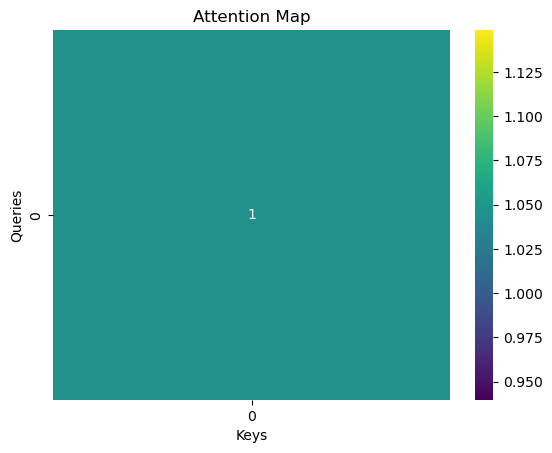

In [16]:
# Assuming attention_weights is a list of tensors, where each tensor is [batch_size, num_queries, num_keys]
# Visualize the attention weights for the first head of the first layer
sns.heatmap(attention_weights[0][0].detach().numpy(), cmap='viridis', annot=True)
plt.title('Attention Map')
plt.xlabel('Keys')
plt.ylabel('Queries')
plt.show()